### A notebook for data exploration and function testing for predict sales web app 

### Contents:
1. Data exploration
2. Feature engineering and train,test and predict split
3. Building and testing model 
4. Testing on unseen shops

## Data exploration

In [111]:
# import libraries
import pandas as pd
import datetime
import math
import numpy as np

### A long cell with functions - please ignore it and scroll past 

In [112]:
def preprocess_data(sales_filepath, items_filepath, use_shop_ids=[38,42,35,23,32,24,4,5,12,29]):
    '''
        preprocess_data() - function that transforms initial training data CSV files into a dataframe 
                            in a format that can be then processed and used in training pipeline
        Input:
            sales_filepath - (str) path to training sales data 
            items_filepath - (str) path to training data on items (names, categories)
            use_shop_ids - (list) a subset of int shop ids from 'sales_filepath' CSV file to use during training to reduce training time
        Output:
            data - (pd.DataFrame) a Pandas dataframe with sales data

    '''
    sales_train = pd.read_csv(sales_filepath)
    items = pd.read_csv(items_filepath)
    data = sales_train[sales_train['shop_id'].isin(use_shop_ids) ].drop(columns=['date_block_num']).reset_index(drop=True)
    data = pd.merge(data, items, on=['item_id'], how='left')    

    return data


def load_data(data_filepath):
    '''
        load_data() - function that creates a Pandas dataframe from given excel file
        Input:
            data_filepath - (str) path to a excel file with sales data in needed format to train on or predict
            Needed columns are: date, shop_id, item_id, item_price, item_cnt_day, item_name, item_category_id
        Output:
            df - (pd.DataFrame) a Pandas dataframe with sales data
    '''
    return pd.read_excel(data_filepath)

def check_data_correctnes(data):
    '''
        check_data_correctnes() - function that checks correctness of a dataframe format and data, and assigns a shop_id if none is given
                                  in case of a single shop in the data
        Input:
            data - (pd.DataFrame) a Pandas dataframe with sales data
            Needed columns are: date, shop_id, item_id, item_price, item_cnt_day, item_name, item_category_id
        Output:
            data - (pd.DataFrame) a Pandas dataframe with sales data with necessary changes if needed (add shop_id if empty),
            OR
            raises an exception to let the web app know that format is incorrect 
    '''
    data['shop_id'] = data['shop_id'].fillna('shop1')
    return data

def clean_and_aggreagate(data):
    '''
        clean_and_aggreagate() - function that cleanes, aggregates and sorts a Pandas dataframe for training or predicting sales
        Input:
            data - (pd.DataFrame) a Pandas dataframe with sales data
        Output:
            data_monthly - (pd.DataFrame) a cleaned and aggregated sorted dataframe
    '''

    # delete data with negative item counts or prices
    data = data[data['item_cnt_day']>0]
    data = data[data['item_price']>0]
    # clean from any null values
    data = data.dropna()
    
    # convert date from string to datetime format
    data['date'] = pd.to_datetime(data['date'])#format='%d.%m.%Y'

    # Add month and year and aggregate data
    data['month'] = data['date'].dt.month
    data['year'] = data['date'].dt.year

    # making sure we are getting only needed columns
    keep_columns_agg = ['shop_id', 'item_id', 'item_price', 'item_cnt_day', 'month', 'year', 'item_category_id']
    
    # aggregate data monthly and by shops and items 
    data_monthly = data[keep_columns_agg].groupby(['year','month', 'shop_id', 'item_category_id', 'item_id'], as_index=False).agg(
        {'item_price':'mean', 
        'item_cnt_day':['sum', 'mean'] })

    # make multilevel index flat
    data_monthly.columns = data_monthly.columns.map(''.join)

    # rename columns
    data_monthly = data_monthly.rename(columns={
        'item_pricemean': 'item_price_avg', 
        'item_cnt_daysum':'item_cnt_month',
        'item_cnt_daymean':'item_cnt_day_mean'})
    
    # sort the dataframe for future analysis
    data_monthly = data_monthly.sort_values(by=['year', 'month', 'shop_id', 'item_id']).reset_index(drop=True)

    return data_monthly

def add_empty_rows(data_monthly):
    '''
        add_empty_rows() - function that extends a dataframe of aggregated sales with skipped rows
                           so that the dataframe has explicit data on zero sales (sets 'item_cnt_month' to zero) 
                           instead of not mentioning an item for a particular month in a particular shop
        Input:
            data_monthly - (pd.DataFrame) a Pandas dataframe with aggregated sales data
        Output:
            data_monthly_ext - (pd.DataFrame) extended dataframe with explicit 0 rows
    '''
    item_ids = data_monthly['item_id'].unique()
    shop_ids = data_monthly['shop_id'].unique()

    start_date_year = int(data_monthly.iloc[0,:]['year'])
    start_date_month = int(data_monthly.iloc[0,:]['month'])
    end_date_year = int(data_monthly.iloc[-1,:]['year'])
    end_date_month = int(data_monthly.iloc[-1,:]['month'])

    # calculate total number of months in the period of historical data
    number_of_months = (end_date_year - start_date_year) * 12 + (end_date_month - start_date_month) + 1
    
    print('Number of months is {}'.format(number_of_months))

    # will have data on all possible combinations of sales records
    # for given shops, items and given time period 
    empty_df = []
    cur_month = start_date_month
    cur_year = start_date_year

    for i in range(number_of_months):
        for shop in shop_ids:
            for item in item_ids:
                empty_df.append([cur_year, cur_month, shop, item])
        
        add_12_if_receive_0 = (12 - 12*math.ceil((cur_month+1)%12 / 12))
        cur_month = (cur_month+1)%12 + add_12_if_receive_0
        
        if cur_month == 1:
            cur_year += 1
        
    empty_df = pd.DataFrame(empty_df, columns=['year', 'month', 'shop_id', 'item_id'])

    data_monthly_ext = pd.merge(empty_df, data_monthly, on=['year','month', 'shop_id','item_id'], how='left')
    # missing records will be filled with 0s
    data_monthly_ext.fillna(0, inplace=True)
    # make sure the dataframe is sorted
    data_monthly_ext = data_monthly_ext.sort_values(by=['year', 'month', 'shop_id', 'item_id']).reset_index(drop=True)

    return data_monthly_ext

def add_global_features(data_monthly_ext):
    # add date_block to split data into train and test
    start_month = data_monthly_ext.iloc[0,:]['month']
    start_year = data_monthly_ext.iloc[0,:]['year']
    # number of months since year 0 in starting date - this will be subtracted to understand how many months we have moved ahead from start
    starting_month_agg = start_year*12 + start_month
    years = np.array(data_monthly_ext['year'])
    months = np.array(data_monthly_ext['month'])
    calculate_block_num = np.vectorize(lambda year, month: (year*12 + month)- starting_month_agg)
    data_monthly_ext['date_block_num'] = calculate_block_num(years, months)

    # Feature engineering
    # add rolling statistics

    rolling_window_size = 3
    # Min value
    f_min = lambda column: column.rolling(window=rolling_window_size, min_periods=1).min()
    # Max value
    f_max = lambda column: column.rolling(window=rolling_window_size, min_periods=1).max()
    # Mean value
    f_mean = lambda column: column.rolling(window=rolling_window_size, min_periods=1).mean()
    # Standard deviation
    f_std = lambda column: column.rolling(window=rolling_window_size, min_periods=1).std()
    
    # keep functions in a list to iterate
    functions = [f_min, f_max, f_mean, f_std]
    # these are suffixes to add to column names to generate new names
    suffixes = ['min', 'max', 'mean', 'std']
    
    # create len(functions) new features
    for i in range(len(functions)):
        data_monthly_ext['item_cnt_roll_{}'.format(suffixes[i])] = data_monthly_ext.groupby(['shop_id','item_id'])['item_cnt_month'].apply(functions[i])

    # Fill the empty std features with 0
    data_monthly_ext['item_cnt_roll_std'].fillna(0, inplace=True)

    # store average number of items sold per month for each item in a shop up to this point using pd.expanding function
    data_monthly_ext['item_mean_past'] = data_monthly_ext.groupby(['shop_id', 'item_category_id'])[['item_cnt_month']].expanding().mean().values

    # store average number of items sold per month for each category in a shop up to this point using pd.expanding function
    data_monthly_ext['category_mean_past'] = data_monthly_ext.groupby(['shop_id', 'item_id'])[['item_cnt_month']].expanding().mean().values


    lag_list = [1, 2, 3]

    # generate shifted number of items sold from the past 1-3 months
    for lag in lag_list:
        feature_name = 'item_cnt_shifted{}'.format(lag)
        data_monthly_ext[feature_name] = data_monthly_ext.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(lag)
        # Fill the empty shifted features with 0
        data_monthly_ext[feature_name].fillna(0, inplace=True)

    # generate trend which shows the change in item sales count
    # trend = current - (previous_1 + ... + previous_n)/n = n*current - previous_1 - ... - previous_n, in our case n=3
    # initially fill with current sales multiplied by number of times we will substract previous values to get average
    data_monthly_ext['item_trend'] = len(lag_list) * data_monthly_ext['item_cnt_month']
    # then subtract previous n values
    for lag in lag_list:
        feature_name = 'item_cnt_shifted{}'.format(lag)
        data_monthly_ext['item_trend'] -= data_monthly_ext[feature_name]
    # then divide by the number of times we have subtracted previous values to get average
    data_monthly_ext['item_trend'] /= len(lag_list) 

    return data_monthly_ext

def create_labels(data_monthly_ext):
    data_monthly_ext['itm_cnt_nxt_mnth'] = data_monthly_ext.groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(-1)
    return data_monthly_ext

def split_train_test_predict(data_monthly_ext):
    # calculate date_block_num for splitting
    num_months = data_monthly_ext['date_block_num'].max() + 1
    # starting from the 3rd month as we have rolling statistics with 3 month window
    train_low = 3
    # get approximately 70% of the data
    train_high = int(0.7 * num_months)
    # testing data will have all the rest of the month up to a last one, which is used for predictiong as it does not have data on next month sales
    test_high = num_months - 1

    train_set = data_monthly_ext.query('date_block_num >= @train_low and date_block_num <= @train_high').copy()
    test_set = data_monthly_ext.query('date_block_num > @train_high and date_block_num < @test_high').copy()
    predict_set = data_monthly_ext.query('date_block_num == @test_high').copy()

    train_set.dropna(subset=['itm_cnt_nxt_mnth'], inplace=True)
    test_set.dropna(subset=['itm_cnt_nxt_mnth'], inplace=True)

    train_set.dropna(inplace=True)
    test_set.dropna(inplace=True)

    return train_set, test_set, predict_set

def generate_global_statistics(dataset, group_by_columns, new_column_names, agg_column='itm_cnt_nxt_mnth', agg_function_names=['mean']):   
    res = dataset.groupby(group_by_columns).agg({agg_column: agg_function_names})
    res.columns = new_column_names
    res.reset_index(inplace=True)
    return res


def add_set_features(train_set, test_set):
    # each new feature will be a statistics computed by grouping and aggregating next month sales by certain dimensions
    # we will generate that grouped statistics and then merge larger ungrouped train and test dataframes with it
    # computing on train data for both train and test as we don't want to give away any information to test set
    # as the calculations are done on future sales
    # since we are dealing with timeseries

    # Item mean
    gp_item_mean = generate_global_statistics(train_set, ['item_id'], ['item_mean_future'])

    # Year mean
    gp_year_mean = generate_global_statistics(train_set, ['year'], ['year_mean_future'])
   
    # Month mean
    gp_month_mean = generate_global_statistics(train_set, ['month'], ['month_mean_future'])
    
    # Category mean
    gp_category_mean = generate_global_statistics(train_set, ['item_category_id'], ['category_mean_future'])
 
    # Shop mean
    gp_shop_mean = generate_global_statistics(train_set, ['shop_id'], ['shop_mean_future'])

    # Shop with item mean
    gp_shop_item_mean = generate_global_statistics(train_set, ['shop_id', 'item_id'], ['shop_item_mean_future'])

    # Add mean encoding features to train set.
    train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
    train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
    train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')
    train_set = pd.merge(train_set, gp_category_mean, on=['item_category_id'], how='left')
    train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
    train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')

    # Add mean encoding features to validation set.
    test_set = pd.merge(test_set, gp_item_mean, on=['item_id'], how='left')
    test_set = pd.merge(test_set, gp_year_mean, on=['year'], how='left')
    test_set = pd.merge(test_set, gp_month_mean, on=['month'], how='left')
    test_set = pd.merge(test_set, gp_category_mean, on=['item_category_id'], how='left')
    test_set = pd.merge(test_set, gp_shop_mean, on=['shop_id'], how='left')
    test_set = pd.merge(test_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')

    return train_set, test_set



def split_data_labels(train_set, test_set, predict_set):
    # create train and test sets and labels. 
    X_train = train_set.drop(['itm_cnt_nxt_mnth', 'date_block_num'], axis=1)
    Y_train = train_set['itm_cnt_nxt_mnth'].astype(int)
    X_test = test_set.drop(['itm_cnt_nxt_mnth', 'date_block_num'], axis=1)
    Y_test = test_set['itm_cnt_nxt_mnth'].astype(int)
    
    # create X_predict to predct next unseen month
    history = pd.concat([train_set, test_set]).drop_duplicates(subset=['item_id'], keep='last')
    X_predict = pd.merge(predict_set, history, on=['item_id'], how='left', suffixes=['', '_'])
    X_predict.drop('itm_cnt_nxt_mnth', axis=1, inplace=True)
    X_predict = X_predict[X_train.columns]

    return X_train, Y_train, X_test, Y_test, X_predict


def save_data(df,filepath):
    '''
        save_data() - a function that saves a Pandas dataframe into a CSV file for later training
                    Not used on new data from web app as that data will be only used for testing and predicting using existing model
        Input:
            df -  a Pandas dataframe with data to save
            filepath - a path to a CSV file where to save the data
        Output:
            None
    '''
    df.to_csv(filepath, index=False)

    return None

def return_processed_data(data):
    data = check_data_correctnes(data)
    data_monthly = clean_and_aggreagate(data)
    data_monthly_ext = add_empty_rows(data_monthly)
    data_monthly_ext = add_global_features(data_monthly_ext)
    data_monthly_ext = create_labels(data_monthly_ext)
    train_set, test_set, predict_set = split_train_test_predict(data_monthly_ext)
    train_set, test_set = add_set_features(train_set, test_set)
    X_train, Y_train, X_test, Y_test, X_predict = split_data_labels(train_set, test_set, predict_set)
    
    # select features that will be used for training, testing and predicting
    features = ['month_mean_future', 'year_mean_future', 'item_mean_future', 'shop_mean_future', 'shop_item_mean_future', 'category_mean_future',
                'category_mean_past', 'item_mean_past', 
                'item_cnt_month', 'item_cnt_day_mean', 
                'item_cnt_roll_mean', 'item_cnt_roll_std', 
                'item_cnt_shifted1', 'item_cnt_shifted2', 'item_cnt_shifted3', 
                'item_trend', 'month']
    X_train = X_train[features]
    X_test = X_test[features]
    X_predict = X_predict[features]

    return X_train, Y_train, X_test, Y_test, X_predict

## 1. Explore data 

In [113]:
data = preprocess_data('data/sales_train.csv', 'data/items.csv', use_shop_ids=range(40))

In [159]:
data.shape

(1820364, 7)

In [163]:
data_agg = clean_and_aggreagate(data)

In [164]:
data_agg.head()

,year,month,shop_id,item_category_id,item_id,item_price_avg,item_cnt_month,item_cnt_day_mean
0,2013,1,0,40,32,221.0,4.0,1.333333
1,2013,1,0,37,33,347.0,2.0,1.000000
2,2013,1,0,40,35,247.0,2.0,1.000000
3,2013,1,0,40,43,221.0,1.0,1.000000
4,2013,1,0,57,51,128.5,2.0,1.000000


In [165]:
data_agg.shape

(1105367, 8)

In [167]:
data_agg.describe().T

,count,mean,std,min,25%,50%,75%,max
year,1105367.0,2013.788742,0.783971,2013.00,2013.0,2014.0,2014.0,2015.0
month,1105367.0,6.318700,3.476001,1.00,3.0,6.0,9.0,12.0
shop_id,1105367.0,21.619381,10.080561,0.00,15.0,25.0,29.0,39.0
item_category_id,1105367.0,41.065893,16.431061,0.00,30.0,40.0,55.0,83.0
item_id,1105367.0,10570.454222,6259.083404,18.00,4906.0,10330.0,16012.5,22169.0
item_price_avg,1105367.0,839.803955,1641.752319,0.07,229.0,399.0,899.0,307980.0
item_cnt_month,1105367.0,2.073591,7.868495,1.00,1.0,1.0,2.0,2246.0
item_cnt_day_mean,1105367.0,1.120589,1.547600,1.00,1.0,1.0,1.0,1000.0


In [187]:
data_agg.tail()

,year,month,shop_id,item_category_id,item_id,item_price_avg,item_cnt_month,item_cnt_day_mean
1105362,2015,12,39,83,22091,179.00,1.0,1.0
1105363,2015,12,39,83,22092,179.00,1.0,1.0
1105364,2015,12,39,42,22100,629.00,1.0,1.0
1105365,2015,12,39,42,22102,1250.00,2.0,1.0
1105366,2015,12,39,37,22140,199.34,1.0,1.0


In [180]:
numb_transactions = data.shape[0]
print('Number of transactions is {}'.format(numb_transactions))

Number of transactions is 1820364


In [181]:
numb_shops = data_agg['shop_id'].nunique()
print('Number of shops is {}'.format(numb_shops))

Number of shops is 40


In [182]:
numb_categories = data_agg['item_category_id'].nunique()
print('Number of categories is {}'.format(numb_categories))

Number of categories is 74


In [183]:
numb_items = data_agg['item_id'].nunique()
print('Number of unique items is {}'.format(numb_items))

Number of unique items is 19111


In [170]:
import seaborn as sns
import matplotlib.pyplot as plt

In [175]:
gp_month_mean = generate_global_statistics(data_agg,group_by_columns=['month'],new_column_names=['item_cnt'], agg_column='item_cnt_month', agg_function_names=['mean'])
gp_month_sum = generate_global_statistics(data_agg,group_by_columns=['month'],new_column_names=['item_cnt'], agg_column='item_cnt_month', agg_function_names=['sum'])

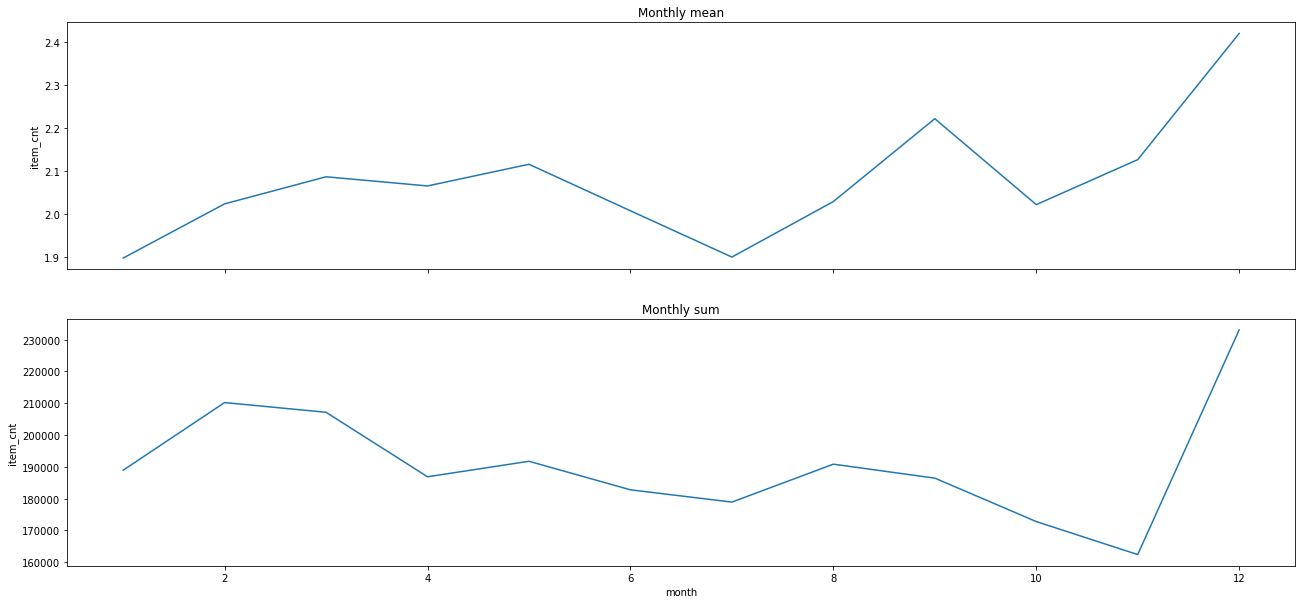

In [176]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

In [177]:
gp_category_mean=generate_global_statistics(data_agg,group_by_columns=['item_category_id'],new_column_names=['item_cnt'], agg_column='item_cnt_month', agg_function_names=['mean'])
gp_category_sum=generate_global_statistics(data_agg,group_by_columns=['item_category_id'],new_column_names=['item_cnt'], agg_column='item_cnt_month', agg_function_names=['sum'])

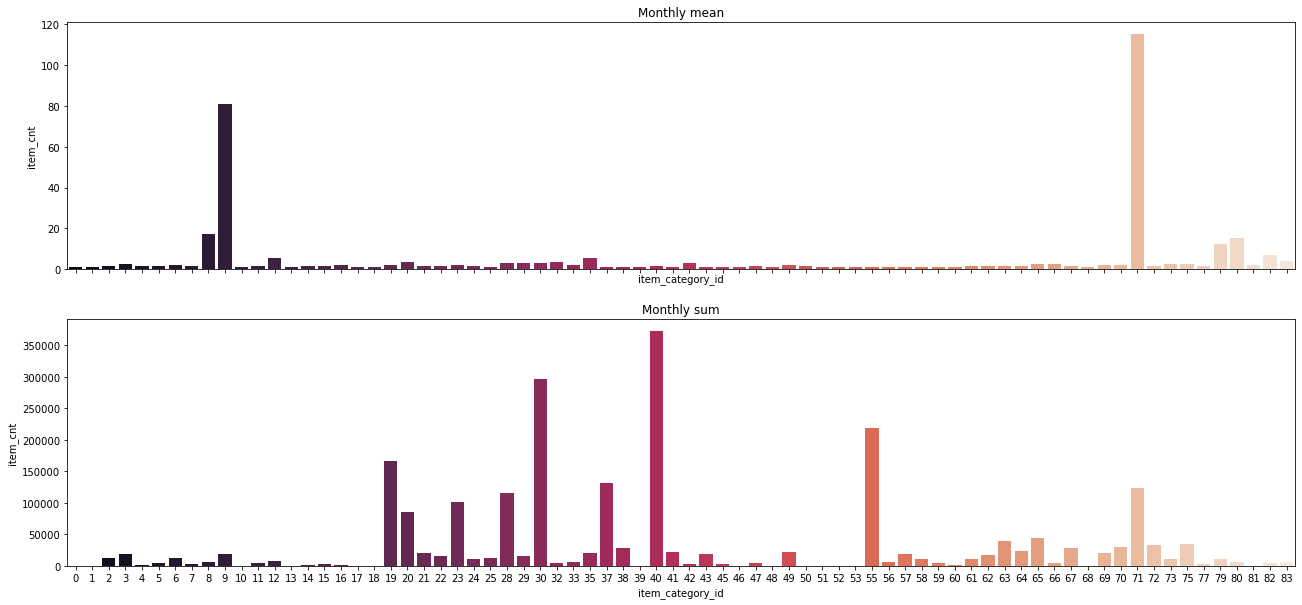

In [178]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

In [184]:
gp_shop_mean=generate_global_statistics(data_agg,group_by_columns=['shop_id'],new_column_names=['item_cnt'], agg_column='item_cnt_month', agg_function_names=['mean'])
gp_shop_sum=generate_global_statistics(data_agg,group_by_columns=['shop_id'],new_column_names=['item_cnt'], agg_column='item_cnt_month', agg_function_names=['sum'])

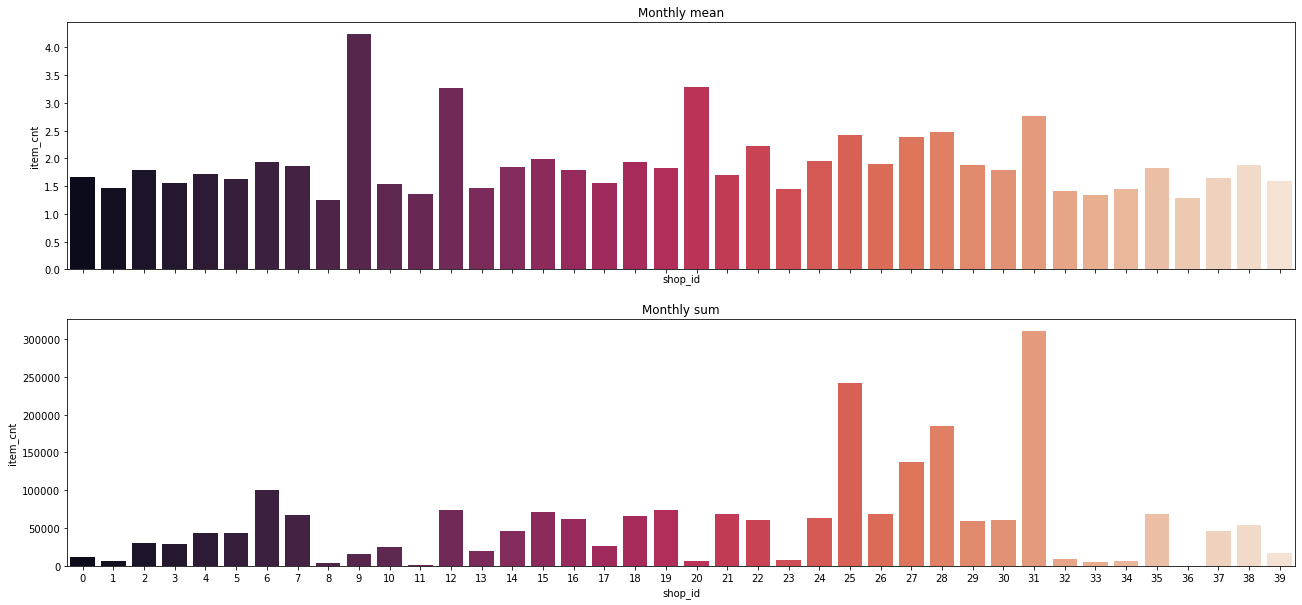

In [185]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

In [ ]:
sns.jointplot(x="item_cnt", y="item_price", data=data_agg, height=8)
plt.show()

## Feature engineering  and train, test split

### Steps below will take significant amount of time

In [117]:
X_train, Y_train, X_test, Y_test, X_predict = return_processed_data(data)

Number of months is 36


In [118]:
X_train.describe()

,month_mean_future,year_mean_future,item_mean_future,shop_mean_future,shop_item_mean_future,category_mean_future,category_mean_past,item_mean_past,item_cnt_month,item_cnt_day_mean,item_cnt_roll_mean,item_cnt_roll_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,month
count,1.758212e+07,1.758212e+07,1.758212e+07,1.758212e+07,1.758212e+07,1.758212e+07,1.758212e+07,1.758212e+07,1.758212e+07,1.758212e+07,1.758212e+07,1.758212e+07,1.758212e+07,1.758212e+07,1.758212e+07,1.758212e+07,1.758212e+07
mean,9.243720e-02,9.243720e-02,9.243720e-02,9.243720e-02,9.243720e-02,9.243720e-02,1.045369e-01,8.182230e-02,9.374381e-02,4.977026e-02,9.600175e-02,9.343206e-02,9.594429e-02,9.831715e-02,9.680465e-02,-3.278217e-03,6.652174e+00
std,1.768931e-02,1.214950e-02,8.252445e-01,1.027715e-01,1.384461e+00,9.591008e-01,9.916559e-01,9.421994e-01,1.722289e+00,4.226347e-01,1.544584e+00,9.221017e-01,1.728929e+00,1.708723e+00,1.623176e+00,1.132574e+00,3.446595e+00
min,7.245042e-02,6.447530e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.636667e+02,1.000000e+00
25%,7.840903e-02,8.734880e-02,3.260870e-03,2.097756e-02,0.000000e+00,3.760085e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,9.266129e-02,8.734880e-02,1.739130e-02,7.244405e-02,0.000000e+00,3.760085e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00
75%,9.607360e-02,1.054355e-01,6.630435e-02,1.095437e-01,4.347826e-02,3.760085e-02,3.448276e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01
max,1.436398e-01,1.054355e-01,1.067359e+02,5.029883e-01,6.871304e+02,1.424738e+02,4.520833e+02,5.003333e+02,1.201000e+03,1.000000e+03,9.213333e+02,5.315377e+02,1.201000e+03,1.201000e+03,1.147000e+03,8.993333e+02,1.200000e+01


In [119]:
Y_train.describe()

count    1.758212e+07
mean     9.243720e-02
std      1.721719e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.201000e+03
Name: itm_cnt_nxt_mnth, dtype: float64

In [120]:
X_test.describe()

,month_mean_future,year_mean_future,item_mean_future,shop_mean_future,shop_item_mean_future,category_mean_future,category_mean_past,item_mean_past,item_cnt_month,item_cnt_day_mean,item_cnt_roll_mean,item_cnt_roll_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,month
count,6.879960e+06,6.879960e+06,6.879960e+06,6.879960e+06,6.879960e+06,6.879958e+06,6.879960e+06,6.879960e+06,6.879960e+06,6.879960e+06,6.879960e+06,6.879960e+06,6.879960e+06,6.879960e+06,6.879960e+06,6.879960e+06,6.879960e+06
mean,9.749250e-02,6.447530e-02,9.243720e-02,9.243720e-02,9.243720e-02,7.698674e-02,1.134504e-01,1.125540e-01,5.412052e-02,3.024355e-02,5.780731e-02,5.936014e-02,5.926125e-02,6.004017e-02,6.939982e-02,-8.779896e-03,7.000000e+00
std,1.687841e-02,4.112988e-12,8.252445e-01,1.027715e-01,1.384461e+00,9.537739e-01,1.699946e+00,1.647324e+00,1.639454e+00,2.986327e-01,1.196433e+00,1.284536e+00,1.659190e+00,1.469942e+00,1.545844e+00,1.566264e+00,2.581989e+00
min,8.435979e-02,6.447530e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.206667e+02,3.000000e+00
25%,9.020263e-02,6.447530e-02,3.260870e-03,2.097756e-02,0.000000e+00,3.760085e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00
50%,9.352467e-02,6.447530e-02,1.739130e-02,7.244405e-02,0.000000e+00,3.760085e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00
75%,9.607360e-02,6.447530e-02,6.630435e-02,1.095437e-01,4.347826e-02,3.760085e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00
max,1.436398e-01,6.447530e-02,1.067359e+02,5.029883e-01,6.871304e+02,1.424738e+02,6.589167e+02,6.110000e+02,2.246000e+03,5.000000e+02,8.436667e+02,1.234521e+03,2.246000e+03,1.604000e+03,1.201000e+03,2.116667e+03,1.100000e+01


In [121]:
Y_test.describe()

count    6.879960e+06
mean     4.914316e-02
std      1.618941e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.246000e+03
Name: itm_cnt_nxt_mnth, dtype: float64

In [122]:
X_predict.describe()

,month_mean_future,year_mean_future,item_mean_future,shop_mean_future,shop_item_mean_future,category_mean_future,category_mean_past,item_mean_past,item_cnt_month,item_cnt_day_mean,item_cnt_roll_mean,item_cnt_roll_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,month
count,7.644400e+05,7.644400e+05,764440.000000,7.644400e+05,764440.000000,764440.000000,764440.000000,764440.000000,764440.000000,764440.000000,764440.000000,764440.000000,764440.000000,764440.000000,764440.000000,764440.000000,764440.0
mean,1.436398e-01,6.447530e-02,0.092437,2.416091e-02,0.024161,0.059597,0.016195,0.092086,0.017605,0.014015,0.031492,0.040457,0.020283,0.056588,0.052796,-0.025617,12.0
std,1.007250e-12,3.744091e-13,0.825245,2.131040e-13,0.398280,1.047995,0.410679,0.669550,0.355506,0.141872,1.038627,1.569036,0.356651,2.812246,2.282558,1.248728,0.0
min,1.436398e-01,6.447530e-02,0.000000,2.416091e-02,0.000000,0.037601,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-775.333333,12.0
25%,1.436398e-01,6.447530e-02,0.003261,2.416091e-02,0.000000,0.037601,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.0
50%,1.436398e-01,6.447530e-02,0.017391,2.416091e-02,0.000000,0.037601,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.0
75%,1.436398e-01,6.447530e-02,0.066304,2.416091e-02,0.000000,0.037601,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.0
max,1.436398e-01,6.447530e-02,106.735870,2.416091e-02,53.260870,142.473761,61.757576,82.636364,165.000000,27.500000,772.666667,1276.010319,152.000000,2246.000000,1604.000000,140.000000,12.0


In [123]:
# import libraries
import sys
import pandas as pd
from sklearn.pipeline import Pipeline
import pickle
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from xgboost import plot_importance
import matplotlib.pyplot as plt

### Long cell of functions for training and evaluation,  please scroll down

In [127]:
def load_data_csv(filepath):
    '''
        load_data() - function that creates a Pandas dataframe by reading data from CSV file
        Input:
            filepath - (str) a filepath to a CSV file where the data is stored
        Output:
            data - (pd.DataFrame) dataframe with data
    '''
    data = pd.read_csv(filepath)
    return data 


def build_model():
    '''
        build_model() - function that creates a model to later train, test and save for predicting
        Input:
            None 
        Output:
            model - a sklearn GridSearchCV object, model to be trained on existing data and predict categories for the new data
    '''
    parameters = {
                "max_depth"        : [ 1, 3],
                "min_child_weight" : [ 7, 10]
    }
    
    # using GridSearch for optimization is not a good idea for time series since we can only test on future data
    #cv_xgb = GridSearchCV(XGBRegressor(), param_grid = parameters, n_jobs=-1, cv=3)
    #model = cv_xgb
    model = XGBRegressor()
    return model


def evaluate_model(model, X_test, y_test):
    '''
        evaluate_model() - function that evaluates an sklearn model
        Input:
            model - a trained sklearn model capable of  'predict' methods
            X_test - data for testing, features
            y_test - labels for testing, targets
        Output:
            MAE - (float) - mean absolute error across all shops and items montly data for period of time defined in X_test dataset
    '''
    # get the model prediction
    y_pred = model.predict(X_test)
    y_pred = y_pred.astype(int)
    MAE = mean_absolute_error(y_test, y_pred)
    return MAE


def save_model(model, model_filepath):
    '''
        save_model() - function that saves a classification model into a Pickle file for later use in web app
        Input:
            model -  a sklearn Pipeline object - model that was trained on existing data and can predict categories for the new data
            model_filepath - a string with a filepath to a Pickle file where ML model, that was trained on the data and is ready to classify new messages, will be stored
        Output:
            None
    '''
    file_pkl = open(model_filepath, 'wb')
    pickle.dump(model, file_pkl)
    file_pkl.close()
    return None

## 3. Building and testing a model 

In [128]:
print('Building model...')
model = build_model()
        
print('Training model...')
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
y_pred = y_pred.astype(int)

print('Evaluating model...')
print('MAE on test data is {}'.format(mean_absolute_error(Y_test, y_pred)) )

Building model...
Training model...
[15:47:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:01] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
Evaluating model...
MAE on test data is 0.05049636916493701


In [134]:
#print('XGBRegressor with this parameters turned out to be the best:', model.best_estimator_.get_params())

In [130]:
model_filepath= 'models/forecast_v1.pkl'
print('Saving model...\n    MODEL: {}'.format(model_filepath))
save_model(model, model_filepath)

Saving model...
    MODEL: models/forecast_v1.pkl


In [131]:
validate_act_vs_pred = pd.DataFrame(zip(Y_test, y_pred), columns=['actual', 'prediction'])
validate_non_zero = validate_act_vs_pred[validate_act_vs_pred['actual'] != 0]
print('Validation MAE on non-zero values:',mean_absolute_error(validate_non_zero['actual'], validate_non_zero['prediction']))

Validation MAE on non-zero values: 1.639324270175785


In [132]:
validate_act_vs_pred

,actual,prediction
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
6879955,0,0
6879956,0,0
6879957,0,0
6879958,0,0


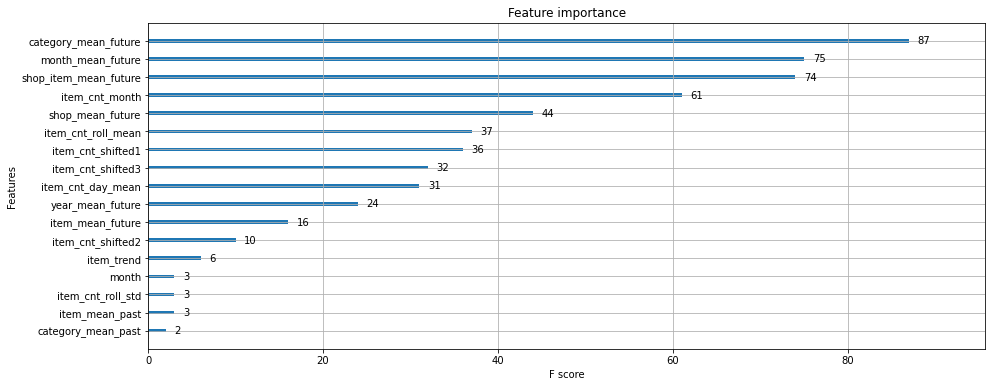

In [186]:
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(model)
plt.show()

## 4. Testing on unseen shops 

In [149]:
data_new = preprocess_data('data/sales_train.csv', 'data/items.csv', use_shop_ids=range(41, 51))

In [150]:
#data = check_data_correctnes(data)
data.describe()

In [151]:
#data_monthly = clean_and_aggreagate(data)
data_monthly.describe()

In [152]:
#data_monthly_ext = add_empty_rows(data_monthly)
data_monthly_ext.describe()

In [153]:
X_train_new, Y_train_new, X_test_new, Y_test_new, X_predict_new = return_processed_data(data_new)

Number of months is 36


In [154]:
y_pred_new = model.predict(X_test_new)
y_pred_new = y_pred_new.astype(int)

print('Evaluating model...')
print('MAE on test data is {}'.format(mean_absolute_error(Y_test_new, y_pred_new)) )

Evaluating model...
MAE on test data is 0.0733879068651704


In [160]:
validate_act_vs_pred_new = pd.DataFrame(zip(Y_test_new, y_pred_new), columns=['actual', 'prediction'])
validate_non_zero_new = validate_act_vs_pred_new[(validate_act_vs_pred_new['actual'] != 0) | (validate_act_vs_pred_new['prediction'] != 0)]
print('Validation MAE on non-zero values:',mean_absolute_error(validate_non_zero_new['actual'], validate_non_zero_new['prediction']))

Validation MAE on non-zero values: 2.8491386382280557


In [156]:
validate_act_vs_pred_new

,actual,prediction
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
1333975,0,0
1333976,0,0
1333977,1,0
1333978,0,0
